In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [4]:
# Load the preprocessed DataFrame
df = pd.read_csv('sample_data/preprocessed_df16000.csv')

In [5]:
# Remove rows with NaN values in the text column
df = df.dropna(how='any', subset=['text'])

# Print the DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15456 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15456 non-null  object
 1   target  15456 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 362.2+ KB


In [6]:
tweet_df = df.copy()

In [7]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.3 MB/s eta 0:00:00


In [8]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification


In [9]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [10]:
# Create the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
max_length = 150  # Adjust as needed
input_ids = []
attention_masks = []

for tweet in tweet_df['text']:
    encoded_dict = tokenizer.encode_plus(
        tweet,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(tweet_df['target'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
len(input_ids),len(attention_masks),len(tweet_df['target'])


(15456, 15456, 15456)

In [14]:
from sklearn.model_selection import train_test_split

train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,tweet_df['target'],attention_masks,test_size=0.2)


In [15]:
print(f'Train inp shape {(train_inp.shape)}')
print(f'Train inp shape {(train_label.shape)}')
print(f'Train inp shape {(train_inp.shape)}')


Train inp shape (12364, 150)
Train inp shape (12364,)
Train inp shape (12364, 150)


In [16]:
model.summary()


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
import mlflow

# Check if the experiment exists, and if not, create it
experiment_name = "bert_model"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///content/mlruns/856822533789005558', creation_time=1695342250217, experiment_id='856822533789005558', last_update_time=1695342250217, lifecycle_stage='active', name='bert_model', tags={}>

In [25]:
mlflow.start_run(description="bert_model")

<ActiveRun: >

In [17]:
# log_dir='tensorboard_data/tb_bert'
# model_save_path='./models/bert_model.h5'

# callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)]

# print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [18]:
history=model.fit([train_inp,train_mask],train_label,batch_size=32,epochs=2,validation_data=([val_inp,val_mask],val_label))


Epoch 1/2
387/387 [==============================] - 453s 1s/step - loss: 0.6242 - accuracy: 0.6374 - val_loss: 0.5800 - val_accuracy: 0.6918
Epoch 2/2
387/387 [==============================] - 401s 1s/step - loss: 0.5350 - accuracy: 0.7315 - val_loss: 0.5943 - val_accuracy: 0.6921


In [19]:

# Evaluate the model on the test set
loss, accuracy = model.evaluate([val_inp,val_mask],val_label)
print(f'Accuracy: {accuracy * 100:.2f}%')



97/97 [==============================] - 34s 354ms/step - loss: 0.5943 - accuracy: 0.6921
Accuracy: 69.21%


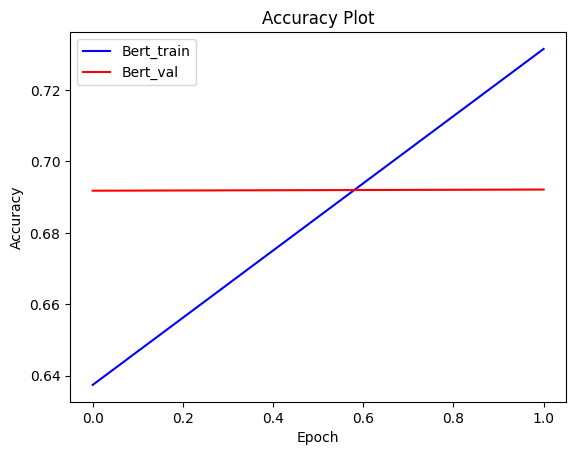

In [26]:
plt.plot(history.history['accuracy'], c= 'b')
plt.plot(history.history['val_accuracy'], c='r')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Bert_train', 'Bert_val'], loc='upper left')
plt.savefig('accuracy_plot.png')
mlflow.log_artifact('accuracy_plot.png')

plt.show()


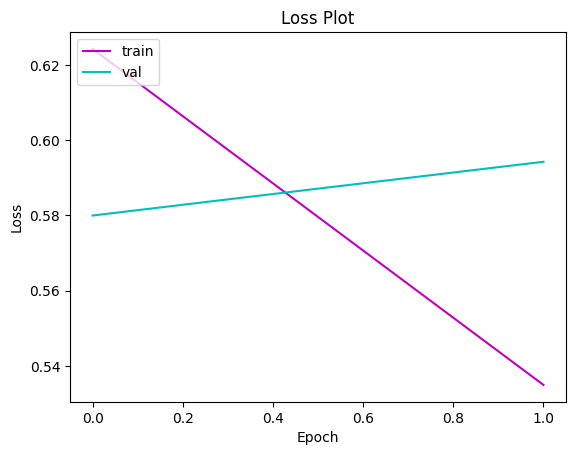

In [27]:

plt.plot(history.history['loss'], c='m')
plt.plot(history.history['val_loss'], c='c')
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('loss_plot.png')
mlflow.log_artifact('loss_plot.png')
plt.show()


In [28]:
# Track your experiment with MLflow
mlflow.log_metrics({'accuracy': accuracy})
mlflow.log_metrics({'loss': loss})

In [29]:
# Log hyperparameters
mlflow.log_params({'pretrained_model_name_or_path': 'bert-base-uncased', 'num_labels': 2})
mlflow.log_params({'epochs': 2, 'batch_size': 32})


In [31]:
import joblib

# Save the model to a file
joblib.dump(model, 'bert_model.pkl')
mlflow.log_artifact('bert_model.pkl')

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [32]:
mlflow.end_run()

In [2]:
!mlflow ui

[2023-09-22 03:06:39 +0200] [23271] [INFO] Starting gunicorn 20.1.0
[2023-09-22 03:06:39 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:39 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:40 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:40 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:41 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:41 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:42 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:42 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:43 +0200] [23271] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2023-09-22 03:06:43 +0200] [23271] [ERROR] Retrying in 1 second.
[2023-09-22 03:06:44 +0200] [23271] [ERROR] Can't connect to ('127.0.0.1', 5000)
Running the mlflow server failed. Please see the logs above for details.
